#Library

In [1]:
import re 
import pickle 
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn import metrics
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from keras.models import load_model




# **Prepare datasets**

In [2]:
df= pd.read_csv('train_preprocess.tsv', sep='\t', header=None)

In [3]:
df.head()

,0,1
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(11000, 2)

In [5]:
df.columns =['text', 'label']
df

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
...,...,...
10995,tidak kecewa,positive
10996,enak rasa masakan nya apalagi kepiting yang me...,positive
10997,hormati partai-partai yang telah berkoalisi,neutral
10998,"pagi pagi di tol pasteur sudah macet parah , b...",negative


#Check Data

In [6]:
fig = px.pie(df, names='label', title ='Pie chart of different sentiments')
fig.show()

In [7]:
df.label.value_counts()

positive    6416
negative    3436
neutral     1148
Name: label, dtype: int64

Kita cek isi datasetnya dan di dalamnya terdapat 11000 data. Terdiri dari:


*   Positive: 6416
*   Neutral: 1148
*   Negative: 3436



# **Text Normalization/Cleansing**

Cleansing data (sumber dari challenge sebelumnya)

In [8]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

#merubah kata kata alay menjadi kata kata baku
#def normalize_alay(text):
    #return ' '.join([data_alay_new_map[word] if word in data_alay_new_map else word for word in text.split(' ')])
def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    #text = normalize_alay(text) # 3
    return text


In [9]:
df['text_clean'] = df.text.apply(preprocess)

In [10]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral,mohon ulama lurus dan k212 mmbri hujjah pa ai ...
2,lokasi strategis di jalan sumatera bandung . t...,positive,lokasi strategis di jalan sumatera bandung tem...
3,betapa bahagia nya diri ini saat unboxing pake...,positive,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative,duh jadi mahasiswa jangan sombong dong kasih k...


#Sortir Data Berdasarkan 3 Sentimen

In [11]:
neg = df.loc[df['label'] == 'negative'].text_clean.tolist()
neu = df.loc[df['label'] == 'neutral'].text_clean.tolist()
pos = df.loc[df['label'] == 'positive'].text_clean.tolist()

neg_label = df.loc[df['label'] == 'negative'].label.tolist()
neu_label = df.loc[df['label'] == 'neutral'].label.tolist()
pos_label = df.loc[df['label'] == 'positive'].label.tolist()

total_data = pos + neu + neg
labels = pos_label + neu_label + neg_label

print('Pos: %s, Neu: %s, Neg: %s' % (len(pos), len(neu), len(neg)))
print('Total data: %s' % len(total_data))


Pos: 6416, Neu: 1148, Neg: 3436
Total data: 11000


#Feature Extraction

In [12]:
max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('tokenizer.pickle has created!')

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created!')

tokenizer.pickle has created!
x_pad_sequences.pickle has created!


In [13]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created!')

y_labels.pickle has created!


#Split Dataset For Training & Testing

In [14]:
file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

#Training (CNN)

In [15]:
embed_dim = 100

model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))


model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())

#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 conv1d (Conv1D)             (None, 92, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 3)                 33        
                                                                 
Total params: 10,065,451
Trainable params: 10,065,451
Non-trainable params: 0
____________________________________________

#Evaluation

In [16]:
predictions = model.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print('Testing selesai')
print(matrix_test)

69/69 [==============================] - 0s 3ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.88      0.83      0.85       685
           1       0.78      0.81      0.79       233
           2       0.92      0.94      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.86      0.86      0.86      2200
weighted avg       0.89      0.89      0.89      2200



#Cross Validation

In [17]:
kf = KFold(n_splits=5,random_state=42,shuffle=True)

accuracies = []

y = Y

embed_dim = 100

for iteration, data in enumerate(kf.split(X), start=1):

    data_train   = X[data[0]]
    target_train = y[data[0]]

    data_test    = X[data[1]]
    target_test  = y[data[1]]

    model = Sequential()
    model.add(Embedding(max_features, embed_dim, input_length=maxlen))
    model.add(layers.Conv1D(128, 5, activation='relu'))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))


    model.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

    

    #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
    history = model.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=0)

    predictions = model.predict(X_test)
    y_pred = predictions

    accuracy = accuracy_score(y_test.argmax(axis=1), y_pred.argmax(axis=1))

    print("Training ke-", iteration)
    print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
    print("======================================================")

    accuracies.append(accuracy)

# this is the average accuracy over all folds
average_accuracy = np.mean(accuracies)

print()
print()
print()
print("Rata-rata Accuracy: ", average_accuracy)


69/69 [==============================] - 0s 2ms/step
Training ke- 1
              precision    recall  f1-score   support

           0       0.88      0.84      0.86       685
           1       0.81      0.75      0.78       233
           2       0.91      0.95      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.87      0.85      0.86      2200
weighted avg       0.89      0.89      0.89      2200

69/69 [==============================] - 0s 5ms/step
Training ke- 2
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       685
           1       0.83      0.73      0.78       233
           2       0.91      0.94      0.93      1282

    accuracy                           0.89      2200
   macro avg       0.87      0.84      0.85      2200
weighted avg       0.89      0.89      0.89      2200

69/69 [==============================] - 0s 2ms/step
Training ke- 3
              precision    recall 

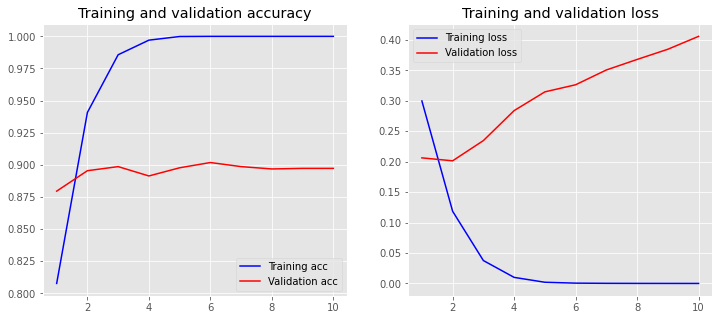

In [18]:
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) +1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1,2,1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

%matplotlib inline
plot_history(history)
  

#Export Model

In [19]:
model.save('model.h5')
print('Model has created!')

Model has created!


#Testing Model

In [20]:
input_text = """ 
bersyukur..,,;,;
"""

sentiment = ['negative', 'neutral', 'positive']

text = [preprocess(input_text)]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])

model = load_model('model.h5')
prediction = model.predict(guess)
polarity = np.argmax(prediction[0])

print('Text: ',text[0])
print('Sentiment: ',sentiment[polarity])

1/1 [==============================] - 0s 175ms/step
Text:   bersyukur 
Sentiment:  positive
